In [1]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [2]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [3]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [5]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [6]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [7]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [8]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [9]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)


# repeating the Y labels for the rnn
N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [10]:
print(training_data_Y[0].shape)

(200,)


In [11]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [12]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [13]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [14]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [15]:
import torch.utils.data

In [16]:
# Dataset Hyper Parameters
num_epochs = 20
batch_size = 100

In [17]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [76]:
# Optimizer Hyper Parameters
learning_rate = 1e-3

from VanillaRNN import VanillaRNN
NUM_CLASSES = 4
VERBOSE = False
net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 50,
                recurrent_use_bias = True,
                recurrent_layer_num = 3,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [50],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


for s in net.parameters():
    print('{}'.format(s.shape))
    
#print(net.rnn_layer.state_dict())

torch.Size([32, 22, 5])
torch.Size([32])
torch.Size([32, 32, 4])
torch.Size([32])
torch.Size([50, 32])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 50])
torch.Size([50, 50])
torch.Size([50])
torch.Size([50])
torch.Size([50, 150])
torch.Size([50])
torch.Size([4, 50])
torch.Size([4])


multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])


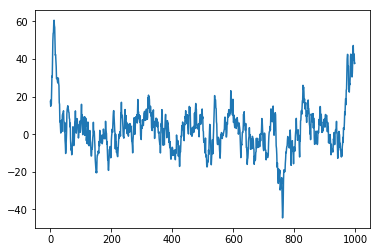

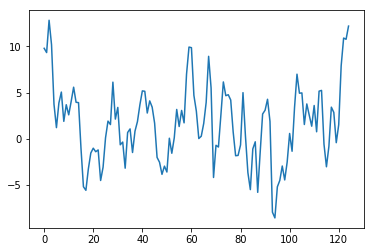

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])


In [19]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
print(out.shape)

8449

multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.42262434959
torch.Size([50])
torch.Size([50, 50])
nl: 0.0
new loss: 1.42262434959


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:76: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [1/17] Loss: [----- 1.4226 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.40850520134
torch.Size([50])
torch.Size([50, 50])
nl: 40.4973678589
new loss: 5.45824241638
Epoch [1/20], Iter [2/17] Loss: [----- 5.4582 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.38954126835
torch.Size([50])
torch.Size([50, 50])
nl: 10.1228942871
new loss: 2.40183067322
Epoch [1/20], Iter [3/17] Loss: [----- 2.4018 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.39501512051
torch.Size([50])
torch.Size([50, 50])
nl: 3.19601464272
new loss: 1.71461653709
Epoch [1/20], Iter [4/17] Loss: [----- 1.7146 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape 

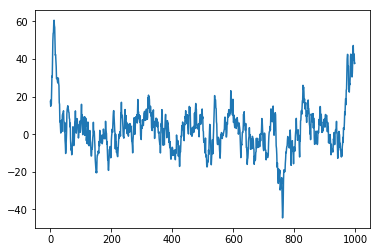

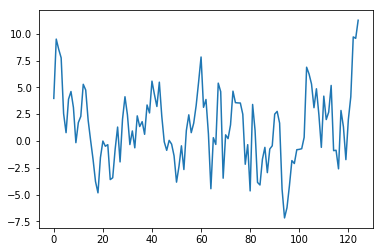

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 26 %


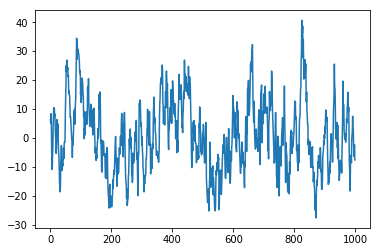

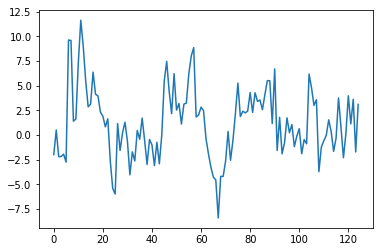

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.37382876873
torch.Size([50])
torch.Size([50, 50])
nl: 6.25380039215
new loss: 1.99920880795
Epoch [2/20], Iter [1/17] Loss: [----- 1.9992 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.40849411488
torch.Size([50])
torch.Size([50, 50])
nl: 11.3230762482
new loss: 2.54080176353
Epoch [2/20], Iter [2/17] Loss: [----- 2.5408 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36786806583
torch.Size([50])
torch.Size([50, 50])
nl: 2.41077685356
new loss: 1.60894572735
Epoch [2/20], I

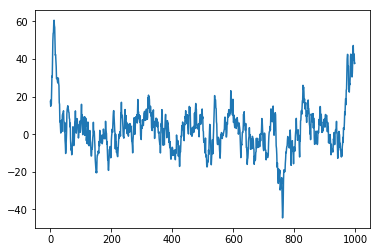

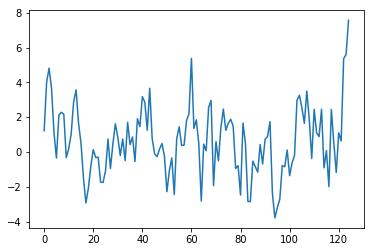

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 29 %


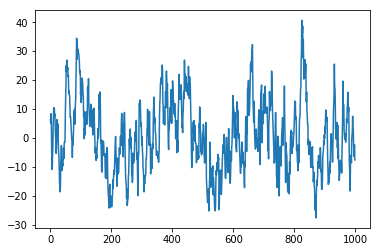

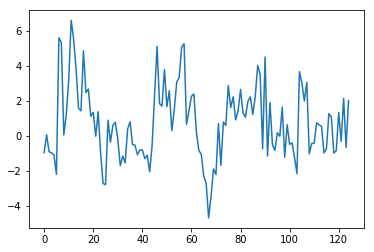

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.38734328747
torch.Size([50])
torch.Size([50, 50])
nl: 52.817199707
new loss: 6.66906356812
Epoch [3/20], Iter [1/17] Loss: [----- 6.6691 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36156582832
torch.Size([50])
torch.Size([50, 50])
nl: 4.4097943306
new loss: 1.80254530907
Epoch [3/20], Iter [2/17] Loss: [----- 1.8025 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.39177930355
torch.Size([50])
torch.Size([50, 50])
nl: 71.5649719238
new loss: 8.54827690125
Epoch [3/20], I

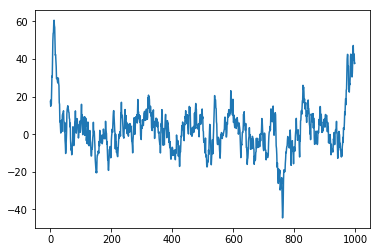

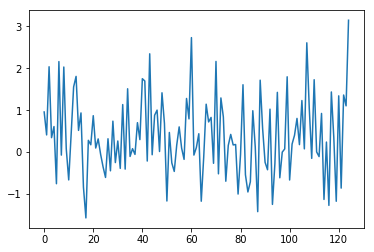

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 30 %


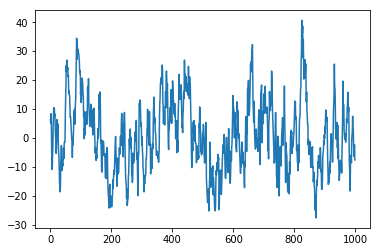

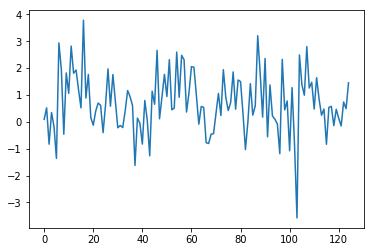

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.37743759155
torch.Size([50])
torch.Size([50, 50])
nl: 7.18692731857
new loss: 2.09613037109
Epoch [4/20], Iter [1/17] Loss: [----- 2.0961 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36750376225
torch.Size([50])
torch.Size([50, 50])
nl: 26.8473720551
new loss: 4.05224084854
Epoch [4/20], Iter [2/17] Loss: [----- 4.0522 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.37915897369
torch.Size([50])
torch.Size([50, 50])
nl: 44.8014945984
new loss: 5.85930871964
Epoch [4/20],

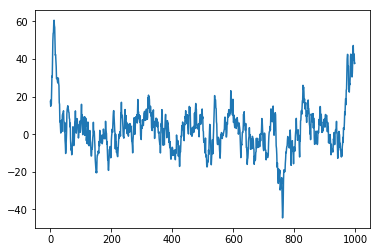

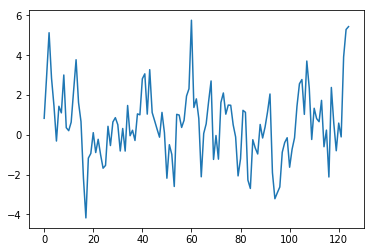

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 33 %


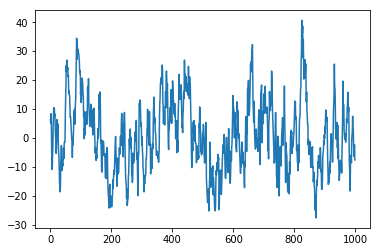

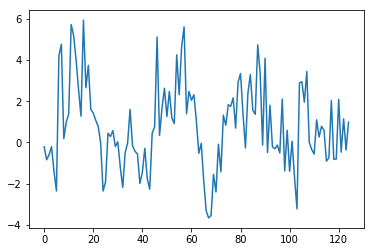

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36094045639
torch.Size([50])
torch.Size([50, 50])
nl: 16.4604263306
new loss: 3.00698328018
Epoch [5/20], Iter [1/17] Loss: [----- 3.0070 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.3700824976
torch.Size([50])
torch.Size([50, 50])
nl: 10.2232913971
new loss: 2.39241170883
Epoch [5/20], Iter [2/17] Loss: [----- 2.3924 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36212229729
torch.Size([50])
torch.Size([50, 50])
nl: 237.069793701
new loss: 25.0691013336
Epoch [5/20], 

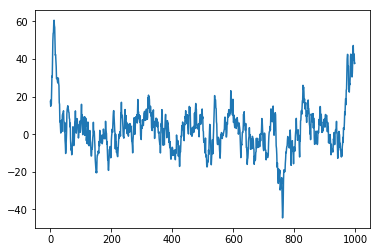

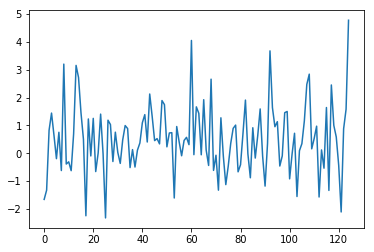

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 35 %


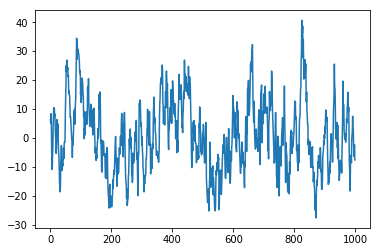

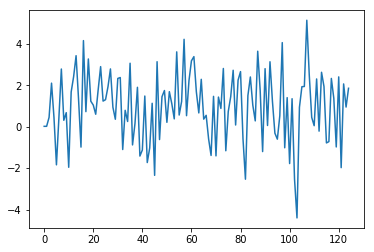

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.33284938335
torch.Size([50])
torch.Size([50, 50])
nl: 8.02536582947
new loss: 2.13538599014
Epoch [6/20], Iter [1/17] Loss: [----- 2.1354 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36117351055
torch.Size([50])
torch.Size([50, 50])
nl: 8.45681858063
new loss: 2.20685529709
Epoch [6/20], Iter [2/17] Loss: [----- 2.2069 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.34065282345
torch.Size([50])
torch.Size([50, 50])
nl: 5.14150094986
new loss: 1.85480284691
Epoch [6/20],

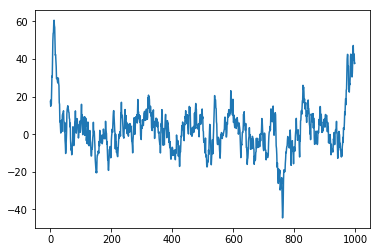

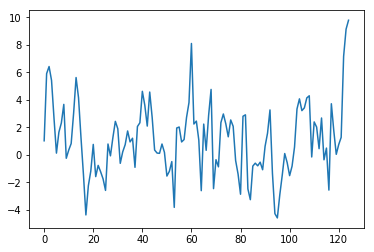

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 38 %


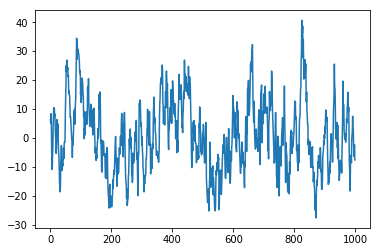

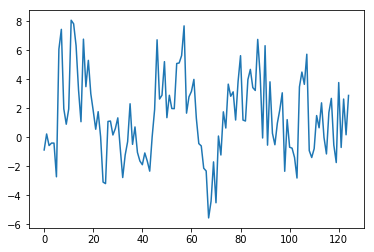

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 24 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.3253070116
torch.Size([50])
torch.Size([50, 50])
nl: 3.14540076256
new loss: 1.63984704018
Epoch [7/20], Iter [1/17] Loss: [----- 1.6398 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.3460804224
torch.Size([50])
torch.Size([50, 50])
nl: 4.87223052979
new loss: 1.83330345154
Epoch [7/20], Iter [2/17] Loss: [----- 1.8333 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.34706616402
torch.Size([50])
torch.Size([50, 50])
nl: 8.17729568481
new loss: 2.16479587555
Epoch [7/20], I

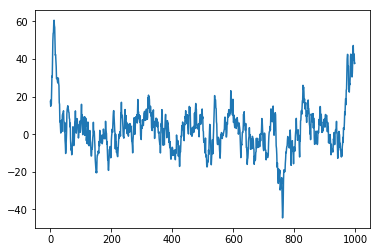

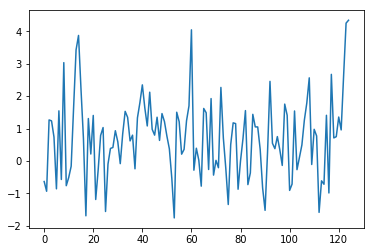

multilayer_h_shape torch.Size([3, 1775, 50])
permuted_h_shape torch.Size([1775, 3, 50])
flattened_h_shape torch.Size([1775, 150])
torch.Size([1775, 4])
Train Accuracy: 39 %


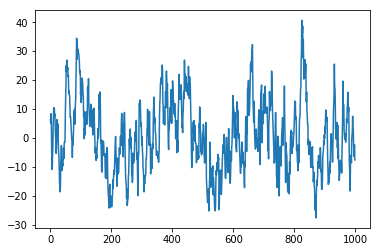

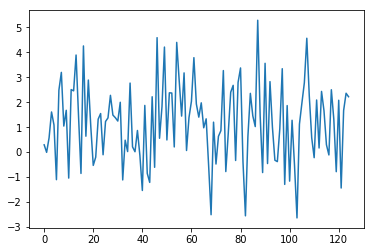

multilayer_h_shape torch.Size([3, 340, 50])
permuted_h_shape torch.Size([340, 3, 50])
flattened_h_shape torch.Size([340, 150])
predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.29513549805
torch.Size([50])
torch.Size([50, 50])
nl: 11.0235624313
new loss: 2.39749193192
Epoch [8/20], Iter [1/17] Loss: [----- 2.3975 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.2907781601
torch.Size([50])
torch.Size([50, 50])
nl: 8.3633480072
new loss: 2.12711286545
Epoch [8/20], Iter [2/17] Loss: [----- 2.1271 -----]
multilayer_h_shape torch.Size([3, 100, 50])
permuted_h_shape torch.Size([100, 3, 50])
flattened_h_shape torch.Size([100, 150])
loss1: 1.36700892448
torch.Size([50])
torch.Size([50, 50])
nl: 5.56526041031
new loss: 1.92353498936
Epoch [8/20], I

In [ ]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        #     for i in range(cnn_training_data_X.shape[0]):
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        #     print images.shape
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
        #if (False): #not FCC_SANITY):
        #    labels = labels.repeat(T, 1)
        #    print('repeated label shape {}'.format((labels.shape)))
        #    labels =  labels.view(-1)
            
        #print(labels)
        labels = Variable(labels)
        
        #print('iteration label mean {}'.format(torch.mean(predicted.float())))

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)
        
        #reshaped_outputs = outputs.view(-1, NUM_CLASSES)
        #reshaped_labels = labels.view(-1)
        
        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        print('loss1: {}'.format(loss1))
        loss1.backward(retain_graph=True)
        
        nl = net.loss_regularizer()
        print('nl: {}'.format(nl))
        
        loss = loss1 + 0.1*nl
        print('new loss: {}'.format(loss))

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
                
        #print(net.rnn_out.grad)
        #print(net.rnn_h.grad)
        
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size, loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    for n,p in net.named_parameters():
        #if n[:6] == 'weight':
        print('===========\ngradient:{}'.format(n))
        print('---------\nmax: {}, mean: {}'.format(torch.max(p.grad), torch.mean(torch.abs(p.grad))))
        #if (p.grad is not None):
            #plt.hist(p.grad)
            #plt.show()
          
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * correct / total))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * correct / total))
    val_acc.append((100 * correct / total))